# Models

In [ ]:
#!pip install auto-sklearn
#!pip install catboost

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import autosklearn.regression
import matplotlib.pyplot as plt
import autosklearn.classification
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score

## Accepted/rejected

In [ ]:
with open('train_dataset_status.pkl', 'rb') as f:
    train_df_status = pickle.load(f)
with open('test_dataset_status.pkl', 'rb') as f:
    test_df_status = pickle.load(f)

In [ ]:
X_train = train_df_status.drop(['Status'], axis=1)
y_train = train_df_status['Status']

X_test = test_df_status.drop(['Status'], axis=1)
y_test = test_df_status['Status']

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

categorical_features = ['Loan Title', 'State']
numerical_features = ['Amount Requested', 'Risk Score', 'Debt-To-Income Ratio', 
                      'Employment Length', 'Application Year', 'Application Month']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
  transformers=[
      ('num', numerical_transformer, numerical_features),
      ('cat', categorical_transformer, categorical_features)
])

#### XGBoost

In [ ]:
xgb = XGBClassifier(eval_metric='auc')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])
params = {
    'classifier__n_estimators': [50, 100, 200, 500, 1000],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.5, 0.7, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 1.0],
}
xgb_model1 = RandomizedSearchCV(pipeline, params, n_iter=4, cv=kf,
                                scoring='roc_auc', random_state=1, verbose=2)
xgb_model1.fit(X_train, y_train)
pickle.dump(xgb_model1, open('1xgb.sav', 'wb'))

In [ ]:
print('Best parameters:')
xgb_model1.best_params_

Best parameters:


{'classifier__subsample': 0.7,
 'classifier__n_estimators': 500,
 'classifier__max_depth': 10,
 'classifier__learning_rate': 0.2,
 'classifier__colsample_bytree': 0.5}

In [ ]:
importances = xgb_model1.best_estimator_.named_steps['classifier'].feature_importances_
feature_importances = [(importance, feature) for importance, feature 
                       in zip(importances, X_train.columns)]
feature_importances.sort(reverse=True)
t = pd.DataFrame(feature_importances, columns=['Importance', 'Feature'])
t[['Feature', 'Importance']].round(2)

,Feature,Importance
0,Debt-To-Income Ratio,0.24
1,Loan Title,0.13
2,Application Year,0.03
3,State,0.02
4,Risk Score,0.02
5,Amount Requested,0.02
6,Application Month,0.01
7,Employment Length,0.01


In [ ]:
y_pred = xgb_model1.predict(X_test)
print('AUC-ROC score:', np.round(xgb_model1.score(X_test, y_test), 3))

AUC-ROC score: 0.995


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     17709
           1       0.74      0.98      0.84      2103

    accuracy                           0.96     19812
   macro avg       0.87      0.97      0.91     19812
weighted avg       0.97      0.96      0.96     19812



### CatBoost

In [ ]:
cat = CatBoostClassifier(eval_metric='AUC')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cat)
])
params = {
    'classifier__iterations': [50, 100, 200, 500, 1000],
    'classifier__depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__bagging_temperature': [0.5, 0.7, 1.0],
    'classifier__border_count': [32, 5, 10, 20, 50, 100, 200],
}
cat_model1 = RandomizedSearchCV(pipeline, params, n_iter=4, cv=kf,
                                scoring='roc_auc', random_state=1, verbose=2)
cat_model1.fit(X_train, y_train)
pickle.dump(cat_model1, open('1catb.sav', 'wb'))

In [ ]:
y_pred = cat_model1.predict(X_test)
print('AUC-ROC score:', np.round(cat_model1.score(X_test, y_test), 3))

AUC-ROC score: 0.992


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     17709
           1       0.65      0.98      0.78      2103

    accuracy                           0.94     19812
   macro avg       0.82      0.96      0.87     19812
weighted avg       0.96      0.94      0.95     19812



### AutoML

In [ ]:
automl_model1 = autosklearn.classification.AutoSklearnClassifier(
  seed=1, n_jobs=-1, metric=autosklearn.metrics.roc_auc
)
automl_model1.fit(X_train, y_train)
pickle.dump(automl_model1, open('1automl.sav', 'wb'))

In [ ]:
y_pred = automl_model1.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print('AUC-ROC score:', np.round(score, 2))

AUC-ROC score: 0.94


In [ ]:
automl_model1.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
45,1,0.70,decision_tree,0.013315,5.735951
167,2,0.24,passive_aggressive,0.031480,7.381560
225,3,0.06,liblinear_svc,0.035600,8.038775


In [ ]:
print(automl_model1.sprint_statistics())

auto-sklearn results:
  Dataset name: 1a567d9f-f028-11ed-bcb0-0242ac1c000c
  Metric: roc_auc
  Best validation score: 0.986685
  Number of target algorithm runs: 276
  Number of successful target algorithm runs: 85
  Number of crashed target algorithm runs: 173
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 17



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     17709
           1       0.52      0.98      0.68      2103

    accuracy                           0.90     19812
   macro avg       0.76      0.94      0.81     19812
weighted avg       0.95      0.90      0.92     19812



 Model comparison:

In [ ]:
data = [
    ['XGBoost', 0.95, 0.96, 0.96, 0.91],
    ['Catboost', 0.992, 0.94, 0.95, 0.87],
    ['AutoML', 0.94, 0.90, 0.92, 0.81]]
columns = ['Model', 'ROC AUC score', 'Accuracy', 'F1 weighted score', 
           'F1 macro score']
t = pd.DataFrame(data, columns=columns)

In [ ]:
t.style.format(precision=2).background_gradient(cmap='PuBu', vmin=0.7, vmax=1)

,Model,ROC AUC score,Accuracy,F1 weighted score,F1 macro score
0,XGBoost,0.95,0.96,0.96,0.91
1,Catboost,0.99,0.94,0.95,0.87
2,AutoML,0.94,0.90,0.92,0.81


The best performed CatBoost model, the worst AutoML.

## Grade

In [ ]:
with open('train_dataset.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('test_dataset.pkl', 'rb') as f:
    test_df = pickle.load(f)

In [ ]:
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
  """Preprocesses the input DataFrame by converting categorical columns to numerical values."""
  df['emp_length'] = df['emp_length'].astype(int)
  d1 = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
  d2 = {'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'B1': 5, 'B2': 6, 'B3': 7, 
        'B4': 8, 'B5': 9, 'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 
        'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E1': 20, 'E2': 21, 
        'E3': 22, 'E4': 23, 'E5': 24, 'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 
        'F5': 29, 'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34}
  d3 = {'Not Verified':0, 'Verified':1, 'Source Verified':2}
  d4 = {'N':0, 'Y':1, 'n':0, 'y':1, 'Cash':0, 'DirectPay':1, 'Individual':0, 
        'Joint App':1, 'f':0, 'w':1, '36 months':0, ' 60 months':1}
  df = df.replace({'grade': d1}).replace({'sub_grade': d2}).replace({'verification_status': d3})
  cols = ['term', 'disbursement_method', 'debt_settlement_flag', 
          'initial_list_status', 'application_type']
  for col in cols:
    df = df.replace({col: d4})  
  return df

In [ ]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [ ]:
np.round(train_df['grade'].value_counts()/len(train_df),3).sort_index()

0    0.143
1    0.143
2    0.143
3    0.143
4    0.143
5    0.143
6    0.143
Name: grade, dtype: float64

In [ ]:
np.round(test_df['grade'].value_counts()/len(test_df),3).sort_index()

0    0.191
1    0.295
2    0.287
3    0.144
4    0.060
5    0.019
6    0.005
Name: grade, dtype: float64

In [ ]:
X_train = train_df.drop(['int_rate', 'grade', 'sub_grade'], axis=1)
y_train = train_df['grade']

X_test = test_df.drop(['int_rate', 'grade', 'sub_grade'], axis=1)
y_test = test_df['grade']

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['home_ownership', 'purpose']
numerical_features = list(X_train.select_dtypes(include=['float', 'int']).columns)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
])

### XGBoost

In [ ]:
xgb = XGBClassifier(objective='multi:softmax', num_class=7)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])
params = {
    'classifier__n_estimators': [50, 100, 200, 500, 1000],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.5, 0.7, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 1.0],
}
xgb_model2  = RandomizedSearchCV(pipeline, params, n_iter=5, cv=kf, n_jobs=-1,
                                scoring='f1_weighted', random_state=0, verbose=2)
xgb_model2.fit(X_train, y_train)
pickle.dump(xgb_model2, open('2xgb.sav', 'wb'))

In [ ]:
y_pred = xgb_model2.best_estimator_.predict(X_test)
print('Score:', np.round(xgb_model2.score(X_test, y_test), 3))

Score: 0.562


In [ ]:
print('Best parameters:')
xgb_model2.best_params_

Best parameters:


{'classifier__subsample': 1.0,
 'classifier__n_estimators': 1000,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 1.0}

In [ ]:
importances = xgb_model2.best_estimator_.named_steps['classifier'].feature_importances_
feature_importances = [(importance, feature) for importance, feature 
                       in zip(importances, X_train.columns)]
feature_importances.sort(reverse=True)
t = pd.DataFrame(feature_importances, columns=['Importance', 'Feature'])
t[['Feature', 'Importance']].round(2).head(15)

,Feature,Importance
0,term,0.20
1,Risk Score,0.08
2,initial_list_status,0.07
3,disbursement_method,0.06
4,inq_last_6mths,0.03
5,installment,0.03
6,verification_status,0.03
7,num_tl_op_past_12m,0.03
8,dti,0.02
9,bc_open_to_buy,0.02


In [ ]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1910
           1       0.66      0.59      0.62      2950
           2       0.61      0.48      0.53      2870
           3       0.42      0.37      0.39      1440
           4       0.23      0.32      0.27       600
           5       0.17      0.41      0.24       190
           6       0.10      0.66      0.18        50

    accuracy                           0.55     10010
   macro avg       0.42      0.52      0.43     10010
weighted avg       0.58      0.55      0.56     10010



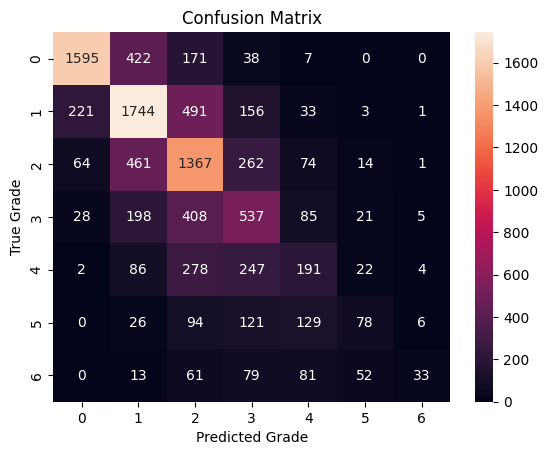

In [ ]:
conf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')
plt.title('Confusion Matrix');

### CatBoost

In [ ]:
cat = CatBoostClassifier(eval_metric='TotalF1:average=Weighted')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cat)
])
params = {
    'classifier__iterations': [50, 100, 200, 500, 1000],
    'classifier__depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__bagging_temperature': [0.5, 0.7, 1.0],
    'classifier__border_count': [32, 5, 10, 20, 50, 100, 200],
}
cat_model2 = RandomizedSearchCV(pipeline, params, n_iter=4, cv=kf, n_jobs=-1,
                                scoring='f1_weighted', random_state=1, verbose=2)
cat_model2.fit(X_train, y_train)
pickle.dump(cat_model2, open('2catb.sav', 'wb'))

In [ ]:
y_pred = cat_model2.predict(X_test)
print('Score:', np.round(cat_model2.score(X_test, y_test), 3))

Score: 0.451


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1910
           1       0.51      0.51      0.51      2950
           2       0.50      0.32      0.39      2870
           3       0.29      0.25      0.27      1440
           4       0.20      0.31      0.24       600
           5       0.14      0.29      0.19       190
           6       0.08      0.60      0.15        50

    accuracy                           0.45     10010
   macro avg       0.34      0.44      0.35     10010
weighted avg       0.47      0.45      0.45     10010



### AutoML

In [ ]:
automl_model2 = autosklearn.classification.AutoSklearnClassifier(
  seed=1, n_jobs=-1, metric=f1_weighted
)
automl_model2.fit(X_train, y_train)
pickle.dump(automl_model2, open('2automl.sav', 'wb'))

In [ ]:
y_pred = automl_model2.predict(X_test)
print('Score:', np.round(automl_model2.score(X_test, y_test), 3))

Score: 0.415


In [ ]:
automl_model2.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
148,1,0.06,lda,0.620653,11.704327
158,2,0.08,lda,0.620866,11.048103
110,3,0.04,lda,0.623254,11.366207
174,4,0.02,lda,0.623639,11.058584
86,5,0.08,lda,0.624922,10.269186
166,6,0.02,lda,0.625458,9.234477
100,7,0.18,lda,0.625545,11.735854
138,8,0.14,lda,0.625724,10.931572
125,9,0.08,lda,0.629530,11.891962


In [ ]:
print(automl_model2.sprint_statistics())

auto-sklearn results:
  Dataset name: 58cfa7f0-f0aa-11ed-9ac2-0242ac1c000c
  Metric: f1_weighted
  Best validation score: 0.379347
  Number of target algorithm runs: 179
  Number of successful target algorithm runs: 70
  Number of crashed target algorithm runs: 76
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 32



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.74      0.65      1910
           1       0.47      0.43      0.45      2950
           2       0.46      0.29      0.35      2870
           3       0.30      0.26      0.28      1440
           4       0.19      0.25      0.21       600
           5       0.10      0.28      0.15       190
           6       0.05      0.48      0.10        50

    accuracy                           0.41     10010
   macro avg       0.31      0.39      0.31     10010
weighted avg       0.44      0.41      0.41     10010



In [ ]:
data = [
    ['XGBoost', 0.56, 0.43, 0.55],
    ['Catboost', 0.45, 0.35, 0.45],
    ['AutoML', 0.41, 0.31, 0.41]]
columns = ['Model', 'F1 weighted score', 'F1 macro score', 'Accuracy']
t = pd.DataFrame(data, columns=columns)

In [ ]:
t.style.format(precision=2).background_gradient(cmap='PuBu', vmin=0, vmax=1)

,Model,F1 weighted score,F1 macro score,Accuracy
0,XGBoost,0.56,0.43,0.55
1,Catboost,0.45,0.35,0.45
2,AutoML,0.41,0.31,0.41


## Interest rate

In [ ]:
with open('train_dataset.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('test_dataset.pkl', 'rb') as f:
    test_df = pickle.load(f)
    
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

X_train = train_df.drop(['int_rate', 'grade', 'sub_grade'], axis=1)
y_train = train_df['int_rate']

X_test = test_df.drop(['int_rate', 'grade', 'sub_grade'], axis=1)
y_test = test_df['int_rate']

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['home_ownership', 'purpose']
numerical_features = list(X_train.select_dtypes(include=['float', 'int']).columns)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
])

In [ ]:
def evaluate_regression(y_pred):
  mse = np.round(mean_squared_error(y_test, y_pred),2)
  rmse = np.round(mean_squared_error(y_test, y_pred, squared=False),2)
  mae = np.round(mean_absolute_error(y_test, y_pred),2)
  r2 = np.round(r2_score(y_test, y_pred),2)
  print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

### XGBoost

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])
params = {
    'regressor__n_estimators': [200, 500, 1000, 1500],
    'regressor__max_depth': [3, 5, 6, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.2]
}
xgb_model3  = RandomizedSearchCV(pipeline, params, n_iter=5, cv=kf, n_jobs=-1,
                                scoring='neg_mean_squared_error', random_state=1, 
                                verbose=2)
xgb_model3.fit(X_train, y_train)
pickle.dump(xgb_model3, open('3xgb.sav', 'wb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
y_pred = xgb_model3.best_estimator_.predict(X_test)
evaluate_regression(y_pred)

MSE: 14.87, RMSE: 3.86, MAE: 2.97, R2: 0.35


### CatBoost

In [ ]:
cat = CatBoostRegressor(eval_metric='RMSE')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cat)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
evaluate_regression(y_pred)

In [ ]:
pipeline.named_steps['classifier'].get_all_params()

In [ ]:
cat = CatBoostRegressor(eval_metric='RMSE')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', cat)
])
params = {
    'regressor__iterations': [200, 500, 1000, 1500],
    'regressor__depth': [3, 5, 6, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.2]
}
cat_model3 = RandomizedSearchCV(pipeline, params, n_iter=5, cv=kf, n_jobs=-1,
                                scoring='neg_mean_squared_error', random_state=1, 
                                verbose=2)
cat_model3.fit(X_train, y_train)
pickle.dump(cat_model2, open('3catb.sav', 'wb'))

In [ ]:
y_pred = cat_model3.best_estimator_.predict(X_test)
evaluate_regression(y_pred)

MSE: 14.84, RMSE: 3.85, MAE: 3.0, R2: 0.35


### AutoML

In [ ]:
automl_model3 = autosklearn.regression.AutoSklearnRegressor(
    seed=1, n_jobs=-1, metric=auto_mean_absolute_error
)
automl_model3.fit(X_train, y_train)
pickle.dump(automl_model3, open('3automl.sav', 'wb'))

In [ ]:
y_pred = automl_model3.predict(X_test)
evaluate_regression(y_pred)

MSE: 16.5, RMSE: 4.06, MAE: 3.23, R2: 0.28


In [ ]:
automl_model3.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
163,1,0.22,ard_regression,3.825424,5.114383
135,2,0.28,liblinear_svr,3.825578,5.658752
176,3,0.02,extra_trees,3.969741,52.879029
136,4,0.06,liblinear_svr,4.015276,5.708076
44,5,0.32,decision_tree,4.096103,5.268003
161,6,0.10,mlp,6.260783,20.930605


In [ ]:
print(automl_model2.sprint_statistics())

auto-sklearn results:
  Dataset name: 58cfa7f0-f0aa-11ed-9ac2-0242ac1c000c
  Metric: f1_weighted
  Best validation score: 0.379347
  Number of target algorithm runs: 179
  Number of successful target algorithm runs: 70
  Number of crashed target algorithm runs: 76
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 32



In [ ]:
data = [
    ['XGBoost', 14.87, 3.86, 2.97, 0.35],
    ['Catboost', 14.84, 3.85, 3.0, 0.35],
    ['AutoML', 16.5, 4.06, 3.23, 0.28]]
columns = ['Model', 'MSE', 'RMSE', 'MAE', 'R2']
t = pd.DataFrame(data, columns=columns)

In [ ]:
t.style.format(precision=2).background_gradient(cmap='PuBu', vmin=12, vmax=17, subset=['MSE'])

,Model,MSE,RMSE,MAE,R2
0,XGBoost,14.87,3.86,2.97,0.35
1,Catboost,14.84,3.85,3.00,0.35
2,AutoML,16.50,4.06,3.23,0.28
